In [1]:
import pandas as pd

df = pd.read_csv("data/raw/train.csv")

df.head()


,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [2]:
df.shape


(22750, 9)

In [3]:
df.columns


Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score', 'Burn Rate'],
      dtype='object')

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [5]:
# Drop ID column (not useful for prediction)
df = df.drop(columns=['Employee ID'])


In [6]:
# Convert Date of Joining to datetime
df['Date of Joining'] = pd.to_datetime(df['Date of Joining'])


In [7]:
# Check missing values
df.isna().sum()


Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

In [8]:
# Remove rows where target is missing
df = df.dropna(subset=['Burn Rate'])


In [9]:
# Fill missing Resource Allocation with median
df['Resource Allocation'] = df['Resource Allocation'].fillna(
    df['Resource Allocation'].median()
)

# Fill missing Mental Fatigue Score with median
df['Mental Fatigue Score'] = df['Mental Fatigue Score'].fillna(
    df['Mental Fatigue Score'].median()
)


In [10]:
df.isna().sum()


Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Burn Rate               0
dtype: int64

In [11]:
# Reference date (latest joining date in dataset)
reference_date = df['Date of Joining'].max()
reference_date
# Calculate tenure in years
df['Tenure_Years'] = (
    (reference_date - df['Date of Joining']).dt.days / 365
)


In [12]:
df = df.drop(columns=['Date of Joining'])


In [13]:
df[['Tenure_Years']].describe()


,Tenure_Years
count,21626.000000
mean,0.500379
std,0.288721
min,0.000000
25%,0.252055
50%,0.498630
75%,0.753425
max,1.000000


In [14]:
categorical_cols = [
    'Gender',
    'Company Type',
    'WFH Setup Available'
]

categorical_cols


['Gender', 'Company Type', 'WFH Setup Available']

In [15]:
df_encoded = pd.get_dummies(
    df,
    columns=categorical_cols,
    drop_first=True  # avoids dummy variable trap
)


In [16]:
df_encoded.shape, df_encoded.columns


((21626, 8),
 Index(['Designation', 'Resource Allocation', 'Mental Fatigue Score',
        'Burn Rate', 'Tenure_Years', 'Gender_Male', 'Company Type_Service',
        'WFH Setup Available_Yes'],
       dtype='object'))

In [17]:
df_encoded.shape, df_encoded.columns


((21626, 8),
 Index(['Designation', 'Resource Allocation', 'Mental Fatigue Score',
        'Burn Rate', 'Tenure_Years', 'Gender_Male', 'Company Type_Service',
        'WFH Setup Available_Yes'],
       dtype='object'))

In [18]:
# X contains all input features used to predict burnout
# y contains the target variable (Burn Rate)

X = df_encoded.drop(columns=['Burn Rate'])
y = df_encoded['Burn Rate']

# Check shapes to confirm separation
X.shape, y.shape


((21626, 7), (21626,))

In [19]:
from sklearn.model_selection import train_test_split

# Split data:
# 80% for training (model learns here)
# 20% for testing (model is evaluated on unseen data)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42  # ensures reproducibility
)

# Confirm sizes
X_train.shape, X_test.shape


((17300, 7), (4326, 7))

In [20]:
from sklearn.preprocessing import StandardScaler

# StandardScaler transforms features to have:
# mean = 0
# standard deviation = 1

scaler = StandardScaler()

# Fit scaler ONLY on training data
# (to avoid data leakage)
X_train_scaled = scaler.fit_transform(X_train)

# Apply same transformation to test data
X_test_scaled = scaler.transform(X_test)


In [21]:
# Confirm final shapes after scaling
X_train_scaled.shape, X_test_scaled.shape


((17300, 7), (4326, 7))

In [22]:
from sklearn.linear_model import LinearRegression

# Create linear regression model
model = LinearRegression()

# Train model on scaled training data
model.fit(X_train_scaled, y_train)
# Predict burnout risk on test data
y_pred = model.predict(X_test_scaled)
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# R² score (explains variance in burnout)
r2 = r2_score(y_test, y_pred)

# Root Mean Squared Error (average prediction error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2, rmse


(0.8678736553454478, np.float64(0.0709399961161482))

In [23]:
# 1. Get the feature names used to train the model
# These come from the encoded dataset (X)
feature_names = X.columns

# 2. Extract regression coefficients from the trained model
# Each coefficient represents how strongly that feature
# affects the Burn Rate (target)
coefficients = model.coef_

# 3. Combine feature names and coefficients into a table
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 4. Compute absolute coefficient values
# This helps measure the STRENGTH of impact (ignoring direction)
importance_df['Absolute_Impact'] = np.abs(importance_df['Coefficient'])

# 5. Sort features by impact (largest effect first)
importance_df = importance_df.sort_values(
    by='Absolute_Impact',
    ascending=False
)

# 6. Display the table
# Interpretation guide:
# - Positive coefficient  -> increases burnout risk
# - Negative coefficient  -> decreases burnout risk
# - Larger absolute value -> stronger influence
importance_df


,Feature,Coefficient,Absolute_Impact
2,Mental Fatigue Score,0.123391,0.123391
1,Resource Allocation,0.062430,0.062430
0,Designation,0.009961,0.009961
6,WFH Setup Available_Yes,-0.008489,0.008489
4,Gender_Male,0.003135,0.003135
3,Tenure_Years,0.000687,0.000687
5,Company Type_Service,0.000151,0.000151


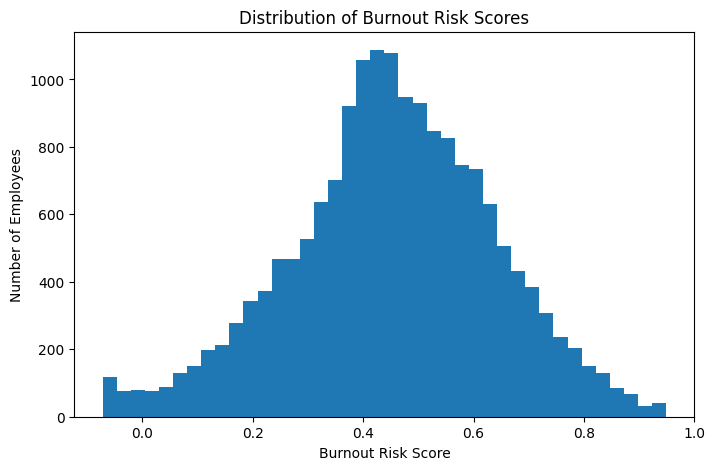

In [24]:
# STEP 11: Create and visualize Burnout Risk Scores
# -------------------------------------------------

import matplotlib.pyplot as plt

# 1. Predict burnout risk for all employees
burnout_scores = model.predict(X_train_scaled)

# 2. Create a DataFrame for analysis
burnout_df = pd.DataFrame({
    'Burnout_Risk_Score': burnout_scores
})

# 3. Plot distribution of burnout risk
plt.figure(figsize=(8, 5))
plt.hist(burnout_df['Burnout_Risk_Score'], bins=40)
plt.xlabel("Burnout Risk Score")
plt.ylabel("Number of Employees")
plt.title("Distribution of Burnout Risk Scores")
plt.show()


In [25]:
# STEP 11A: Train multiple models and compare performance
# ------------------------------------------------------
# Goal: Show that we tested different modeling approaches
# (linear + regularized + nonlinear) and picked the best.

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

models = {
    "LinearRegression": model,  # your already-trained baseline
    "Ridge(alpha=1.0)": Ridge(alpha=1.0, random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
    "HistGradientBoosting": HistGradientBoostingRegressor(
        random_state=42
    )
}

results = []

for name, m in models.items():
    # Train (skip retraining baseline if it's already fitted)
    if name != "LinearRegression":
        m.fit(X_train_scaled, y_train)

    # Predict
    preds = m.predict(X_test_scaled)

    # Metrics
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    results.append((name, r2, rmse))

results_df = pd.DataFrame(results, columns=["Model", "R2", "RMSE"]).sort_values("R2", ascending=False)
results_df


,Model,R2,RMSE
3,HistGradientBoosting,0.904961,0.060165
2,RandomForest,0.890297,0.064641
1,Ridge(alpha=1.0),0.867874,0.070940
0,LinearRegression,0.867874,0.070940


In [26]:
# STEP 12A: Predictions using best model (HistGradientBoosting)

best_model = models["HistGradientBoosting"]

y_test_pred = best_model.predict(X_test_scaled)


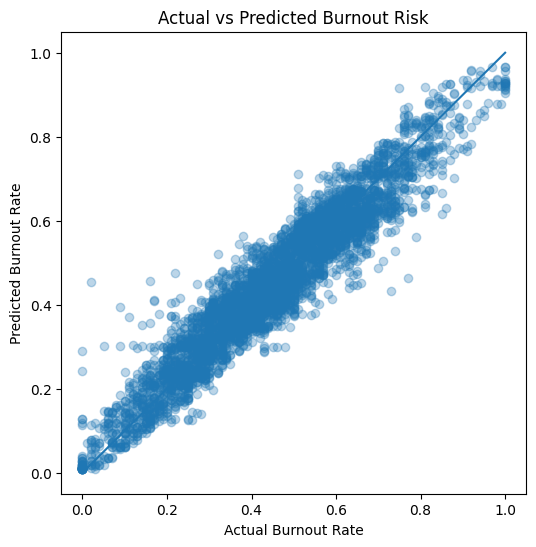

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.plot([0, 1], [0, 1])  # perfect prediction line
plt.xlabel("Actual Burnout Rate")
plt.ylabel("Predicted Burnout Rate")
plt.title("Actual vs Predicted Burnout Risk")
plt.show()


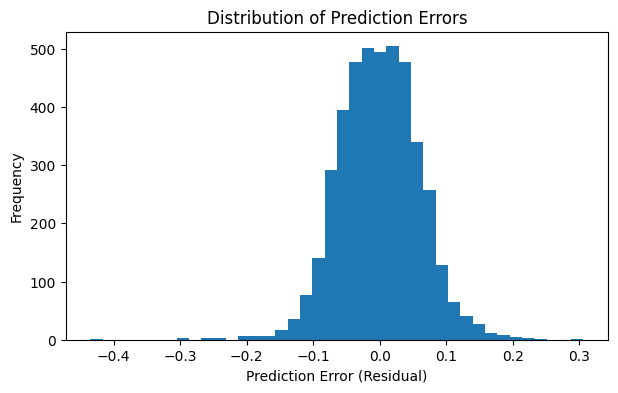

In [28]:
# Residuals
residuals = y_test - y_test_pred

plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=40)
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()


In [29]:
# Create risk bands
risk_band = pd.cut(
    y_test_pred,
    bins=[0, 0.33, 0.66, 1.0],
    labels=["Low", "Medium", "High"]
)

error_df = pd.DataFrame({
    "Risk Band": risk_band,
    "Absolute Error": abs(residuals)
})

error_df.groupby("Risk Band").mean()


/var/folders/bc/2p8bb0kn58q4dvw7z83tyfvc0000gn/T/ipykernel_15784/2788271720.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_df.groupby("Risk Band").mean()


,Absolute Error
Risk Band,
Low,0.039486
Medium,0.049904
High,0.049500


/var/folders/bc/2p8bb0kn58q4dvw7z83tyfvc0000gn/T/ipykernel_15784/358671592.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_df.groupby("Risk Band").mean().plot(kind="bar", legend=False)


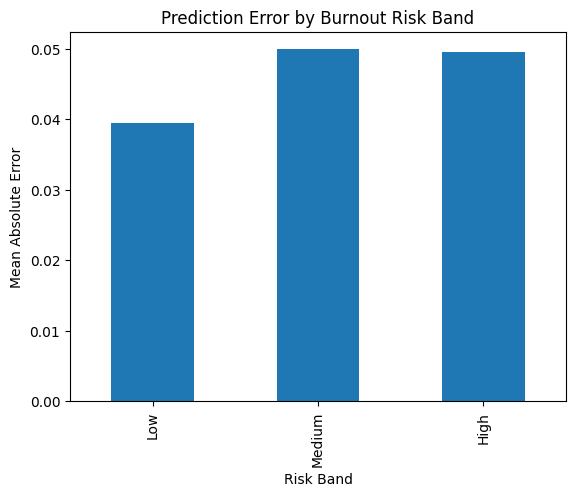

In [30]:
error_df.groupby("Risk Band").mean().plot(kind="bar", legend=False)
plt.ylabel("Mean Absolute Error")
plt.title("Prediction Error by Burnout Risk Band")
plt.show()


In [31]:
# STEP 13: High-risk employee profiling
# ------------------------------------
# Goal:
# Compare characteristics of LOW vs HIGH burnout risk groups
# to generate actionable insights.

# Create burnout risk bands from predictions
risk_band = pd.cut(
    y_test_pred,
    bins=[0, 0.33, 0.66, 1.0],
    labels=["Low", "Medium", "High"]
)

# Combine predictions with original test features
profile_df = X_test.copy()
profile_df["Predicted_Burnout"] = y_test_pred
profile_df["Risk_Band"] = risk_band

# Focus only on LOW and HIGH risk groups
low_high_df = profile_df[profile_df["Risk_Band"].isin(["Low", "High"])]

# Compare mean feature values
comparison = low_high_df.groupby("Risk_Band").mean()

comparison


/var/folders/bc/2p8bb0kn58q4dvw7z83tyfvc0000gn/T/ipykernel_15784/447227647.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comparison = low_high_df.groupby("Risk_Band").mean()


,Designation,Resource Allocation,Mental Fatigue Score,Tenure_Years,Gender_Male,Company Type_Service,WFH Setup Available_Yes,Predicted_Burnout
Risk_Band,,,,,,,,
Low,1.071361,2.268316,3.443578,0.494715,0.379638,0.650809,0.715509,0.211549
Medium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
High,3.632530,7.401606,8.380522,0.497387,0.550201,0.628514,0.313253,0.759470


In [32]:
import os
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

os.makedirs("reports", exist_ok=True)

# Predictions on test set using best model
y_test_pred = best_model.predict(X_test_scaled)

pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_test_pred
}).to_csv("reports/test_predictions.csv", index=False)

# Permutation importance (model-agnostic)
perm = permutation_importance(
    best_model,
    X_test_scaled,
    y_test,
    n_repeats=5,
    random_state=42,
    scoring="r2"
)

imp_df = pd.DataFrame({
    "Feature": list(X.columns),
    "ImportanceMean": perm.importances_mean,
    "ImportanceStd": perm.importances_std
}).sort_values("ImportanceMean", ascending=False)

imp_df.to_csv("reports/permutation_importance.csv", index=False)

print("✅ Saved reports/test_predictions.csv and reports/permutation_importance.csv")


✅ Saved reports/test_predictions.csv and reports/permutation_importance.csv
